#Load the Dataset

In [1]:
import pandas as pd

# Define file paths
numerals_path = "./dataset/numerals.csv"
vowels_path = "./dataset/vowels.csv"
consonants_path = "./dataset/consonants.csv"

# Load each CSV file separately
df_numerals = pd.read_csv(numerals_path)
df_vowels = pd.read_csv(vowels_path)
df_consonants = pd.read_csv(consonants_path)

# Display the first few rows of each
print("Numerals Labels:\n", df_numerals.head())
print("Vowels Labels:\n", df_vowels.head())
print("Consonants Labels:\n", df_consonants.head())


Numerals Labels:
    Class  Label Devanagari Label Phonetics
0      0      0                ०    Śūn'ya
1      1      1                १       ēka
2      2      2                २      du'ī
3      3      3                ३      tīna
4      4      4                ४      cāra
Vowels Labels:
    Class Label Devanagari Label Phonetics
0      1     a                अ         a
1      2    aa                आ         ā
2      3     i                इ         i
3      4    ee                ई         ī
4      5     u                उ         u
Consonants Labels:
    Class Label Devanagari Label Phonetics
0      1    ka                क        ka
1      2   kha                ख       kha
2      3    ga                ग        ga
3      4   gha                घ       gha
4      5   kna                ङ        ṅa


In [2]:
import os
import pandas as pd
from tqdm import tqdm

dataset_path = "./dataset/nhcd"
train_data, val_data, test_data = [], [], []  # Separate lists for splits

# Function to process a directory
def process_directory(df, folder_name):
    count = 0  # Counter to distribute images sequentially
    
    for _, row in df.iterrows():
        class_id = str(row["Class"])
        label = row["Devanagari Label"]  # Using Devanagari character as the label
        
        char_folder = os.path.join(dataset_path, folder_name, class_id)
        if os.path.exists(char_folder):
            # Group images by their prefix (001, 002, ..., 046)
            prefix_dict = {}
            img_files = sorted(os.listdir(char_folder))

            for img_file in img_files:
                prefix = img_file.split("_")[0]  # Extract prefix (e.g., '001' from '001_01.png')

                if prefix not in prefix_dict:
                    prefix_dict[prefix] = []  # Initialize list for the prefix

                prefix_dict[prefix].append(img_file)

            # Assign images to train, validation, and test sets using a counter
            for prefix, files in prefix_dict.items():
                selected_files = files[:2]  # Take only first 2 images per prefix
                
                for img_file in selected_files:
                    img_path = os.path.join(char_folder, img_file)
                    data_entry = {"image_path": img_path, "label": label}

                    # Distribute using counter
                    if count % 10 < 8:  # 70% Train
                        train_data.append(data_entry)
                    elif count % 10 < 9:  # 20% Validation
                        val_data.append(data_entry)
                    else:  # 10% Test
                        test_data.append(data_entry)

                    count += 1  # Increment counter


# Process all three sets
process_directory(df_numerals, "numerals")
process_directory(df_vowels, "vowels")
process_directory(df_consonants, "consonants")

# Convert to DataFrame
df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)
df_test = pd.DataFrame(test_data)

print(f"Train Set: {len(df_train)} images")
print(f"Validation Set: {len(df_val)} images")
print(f"Test Set: {len(df_test)} images")

# Save if needed
df_train.to_csv("train_set.csv", index=False)
df_val.to_csv("val_set.csv", index=False)
df_test.to_csv("test_set.csv", index=False)


Train Set: 3748 images
Validation Set: 467 images
Test Set: 467 images


In [3]:
from datasets import Dataset
from PIL import Image

# Convert to HuggingFace dataset format
dataset_train = Dataset.from_pandas(df_train)
dataset_validate = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

# Function to open image
def load_image(example):
    example["image"] = Image.open(example["image_path"]).convert("RGB")
    return example

dataset_train = dataset_train.map(load_image)
dataset_validate = dataset_validate.map(load_image)
dataset_test = dataset_test.map(load_image)

print("Total train images loaded:", len(dataset_train))
print("Total validate images loaded:", len(dataset_validate))
print("Total test images loaded:", len(dataset_test))

c:\Users\Amrit Baskota\Desktop\DevNagariOCR\trocr_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 467/467 [00:00<00:00, 1913.90 examples/s]

Total train images loaded: 3748
Total validate images loaded: 467
Total test images loaded: 467


In [4]:
# from datasets import DatasetDict

# # Define split ratios (e.g., 80% train, 20% validation)
# train_test_split = dataset.train_test_split(test_size=0.2, seed=42)

# # If you also need a test set, further split the validation set
# train_valid_test_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)

# # Combine into a single DatasetDict
# dataset_splits = DatasetDict({
#     "train": train_test_split["train"],
#     "validation": train_valid_test_split["train"],
#     "test": train_valid_test_split["test"]
# })

# # Check split sizes
# print(dataset_splits)


In [5]:
from transformers import TrOCRProcessor
import torch

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# Longest label
# max(len(label) for label in df_train["label"])  # 3

# Define max_length (based on longest label, slight high for flexibility)
MAX_LENGTH = 5 

def preprocess_function(example):
    # Process image
    pixel_values = processor(example["image"], return_tensors="pt").pixel_values.squeeze(0)  
    
    # Tokenize label with padding
    label_ids = processor.tokenizer(
        example["label"],
        padding="max_length",  # Pad to MAX_LENGTH
        truncation=True,       # Ensure fixed size
        max_length=MAX_LENGTH,
        return_tensors="pt"
    ).input_ids.squeeze(0)
    
    return {"pixel_values": pixel_values, "labels": label_ids}

# Apply processing with batched mapping
dataset_train = dataset_train.map(
    preprocess_function, remove_columns=["image", "label"], batched=True
)
dataset_validate = dataset_validate.map(
    preprocess_function, remove_columns=["image", "label"], batched=True
)

# Check data shape
print(dataset_train[0])  # Ensure labels have fixed length

Map: 100%|██████████| 467/467 [00:06<00:00, 77.33 examples/s]


{'image_path': './dataset/nhcd\\numerals\\0\\001_01.jpg', 'pixel_values': [[[0.9843137264251709, 0.9843137264251709, 0.9843137264251709, 0.9843137264251709, 0.9843137264251709, 0.9843137264251709, 0.9843137264251709, 0.9843137264251709, 0.9843137264251709, 0.9764705896377563, 0.9764705896377563, 0.9764705896377563, 0.9764705896377563, 0.9764705896377563, 0.9686274528503418, 0.9686274528503418, 0.9686274528503418, 0.9686274528503418, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9607843160629272, 0.9686274528503418, 0.9686274528503418, 0.9764705896377563, 0.9764705896377563, 0.9764705896377563, 0.9843137264251709, 0.9843137264251709, 0.9843137264251709, 0.9921568632125854, 0.9921568632125854, 0.9

In [6]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['

In [7]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.get_device_name())


True
1
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments


# training_args = Seq2SeqTrainingArguments(
#     per_device_train_batch_size=2,
#     gradient_accumulation_steps=4,
#     num_train_epochs=10,
#     predict_with_generate=True,
#     evaluation_strategy="steps",
#     output_dir="./checkpoints/",
#     logging_steps=10,
#     save_steps=2000,
#     eval_steps=2000,
#     fp16=True,
#     load_best_model_at_end=True,
#     save_total_limit=2,  # Keep only 2 latest checkpoints
# )

training_args = Seq2SeqTrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=6,  # Early stopping will prevent excessive training
    eval_strategy="steps",
    output_dir="./trOCR_v2/",
    logging_steps=100,  # Log every 100 steps
    save_steps=500,  # Save model more frequently
    eval_steps=100,  # Evaluate more frequently
    gradient_checkpointing=True,  # Reduce memory usage
    load_best_model_at_end=True,
    predict_with_generate=True,  # Enables text generation for validation
    logging_dir="./logs",  # Logs directory
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU supports it
)



In [9]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model.to(device)



Using device: cuda


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [10]:
from transformers import EarlyStoppingCallback
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_validate,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Start training
trainer.train()

                                                   
  1%|▏         | 20/1404 [09:12<6:45:32, 17.58s/it]

{'eval_loss': 0.9973840713500977, 'eval_runtime': 195.2451, 'eval_samples_per_second': 2.392, 'eval_steps_per_second': 0.302, 'epoch': 0.09}


                                                    
  3%|▎         | 40/1404 [18:28<6:55:25, 18.27s/it]

{'eval_loss': 0.8705172538757324, 'eval_runtime': 200.898, 'eval_samples_per_second': 2.325, 'eval_steps_per_second': 0.294, 'epoch': 0.17}


                                                    
  4%|▍         | 60/1404 [27:20<6:32:51, 17.54s/it]

{'eval_loss': 0.7835668921470642, 'eval_runtime': 184.1208, 'eval_samples_per_second': 2.536, 'eval_steps_per_second': 0.32, 'epoch': 0.26}


                                                    
  6%|▌         | 80/1404 [36:35<6:37:34, 18.02s/it]

{'eval_loss': 0.7920494675636292, 'eval_runtime': 190.421, 'eval_samples_per_second': 2.452, 'eval_steps_per_second': 0.31, 'epoch': 0.34}


  7%|▋         | 100/1404 [42:22<6:18:55, 17.44s/it]

{'loss': 1.3843, 'grad_norm': 8.061577796936035, 'learning_rate': 1.8575498575498575e-05, 'epoch': 0.43}


                                                    
  7%|▋         | 100/1404 [45:23<6:18:55, 17.44s/it]

{'eval_loss': 0.6124980449676514, 'eval_runtime': 181.8535, 'eval_samples_per_second': 2.568, 'eval_steps_per_second': 0.324, 'epoch': 0.43}


                                                     
  9%|▊         | 120/1404 [54:17<6:12:49, 17.42s/it]

{'eval_loss': 0.4529617130756378, 'eval_runtime': 187.419, 'eval_samples_per_second': 2.492, 'eval_steps_per_second': 0.315, 'epoch': 0.51}


                                                      
 10%|▉         | 140/1404 [1:03:11<6:07:20, 17.44s/it]

{'eval_loss': 0.3849536180496216, 'eval_runtime': 186.6198, 'eval_samples_per_second': 2.502, 'eval_steps_per_second': 0.316, 'epoch': 0.6}


                                                       
 11%|█▏        | 160/1404 [1:12:01<6:01:37, 17.44s/it]

{'eval_loss': 0.29394394159317017, 'eval_runtime': 180.6404, 'eval_samples_per_second': 2.585, 'eval_steps_per_second': 0.327, 'epoch': 0.68}


                                                       
 13%|█▎        | 180/1404 [1:20:50<5:54:19, 17.37s/it]

{'eval_loss': 0.23179024457931519, 'eval_runtime': 183.502, 'eval_samples_per_second': 2.545, 'eval_steps_per_second': 0.322, 'epoch': 0.77}


 14%|█▍        | 200/1404 [1:26:37<5:51:11, 17.50s/it] 

{'loss': 0.401, 'grad_norm': 7.256718635559082, 'learning_rate': 1.7150997150997152e-05, 'epoch': 0.85}


                                                      
 14%|█▍        | 200/1404 [1:29:41<5:51:11, 17.50s/it]

{'eval_loss': 0.19639471173286438, 'eval_runtime': 184.3429, 'eval_samples_per_second': 2.533, 'eval_steps_per_second': 0.32, 'epoch': 0.85}


                                                       
 16%|█▌        | 220/1404 [1:38:34<5:44:39, 17.47s/it]

{'eval_loss': 0.17537745833396912, 'eval_runtime': 184.9473, 'eval_samples_per_second': 2.525, 'eval_steps_per_second': 0.319, 'epoch': 0.94}


                                                       
 17%|█▋        | 240/1404 [1:47:27<5:37:14, 17.38s/it]

{'eval_loss': 0.1433662623167038, 'eval_runtime': 184.2723, 'eval_samples_per_second': 2.534, 'eval_steps_per_second': 0.32, 'epoch': 1.02}


                                                       
 19%|█▊        | 260/1404 [1:56:18<5:30:53, 17.35s/it]

{'eval_loss': 0.1279711127281189, 'eval_runtime': 185.1534, 'eval_samples_per_second': 2.522, 'eval_steps_per_second': 0.319, 'epoch': 1.11}


                                                       
 20%|█▉        | 280/1404 [2:05:06<5:26:05, 17.41s/it]

{'eval_loss': 0.0994662195444107, 'eval_runtime': 182.0844, 'eval_samples_per_second': 2.565, 'eval_steps_per_second': 0.324, 'epoch': 1.2}


 21%|██▏       | 300/1404 [2:10:51<5:18:43, 17.32s/it] 

{'loss': 0.1338, 'grad_norm': 6.341590881347656, 'learning_rate': 1.5726495726495726e-05, 'epoch': 1.28}


                                                      
 21%|██▏       | 300/1404 [2:13:54<5:18:43, 17.32s/it]

{'eval_loss': 0.14529743790626526, 'eval_runtime': 182.751, 'eval_samples_per_second': 2.555, 'eval_steps_per_second': 0.323, 'epoch': 1.28}


                                                       
 23%|██▎       | 320/1404 [2:22:40<5:12:28, 17.30s/it]

{'eval_loss': 0.11982767283916473, 'eval_runtime': 181.4817, 'eval_samples_per_second': 2.573, 'eval_steps_per_second': 0.325, 'epoch': 1.37}


                                                       
 24%|██▍       | 340/1404 [2:31:34<5:08:23, 17.39s/it]

{'eval_loss': 0.10962594300508499, 'eval_runtime': 187.5292, 'eval_samples_per_second': 2.49, 'eval_steps_per_second': 0.315, 'epoch': 1.45}


                                                       
 26%|██▌       | 360/1404 [2:40:32<5:01:55, 17.35s/it]

{'eval_loss': 0.11760671436786652, 'eval_runtime': 193.3247, 'eval_samples_per_second': 2.416, 'eval_steps_per_second': 0.305, 'epoch': 1.54}


                                                       
 27%|██▋       | 380/1404 [2:49:21<4:56:00, 17.34s/it]

{'eval_loss': 0.1141989454627037, 'eval_runtime': 182.3829, 'eval_samples_per_second': 2.561, 'eval_steps_per_second': 0.323, 'epoch': 1.62}


 28%|██▊       | 400/1404 [2:55:07<4:50:40, 17.37s/it] 

{'loss': 0.1006, 'grad_norm': 8.656262397766113, 'learning_rate': 1.4301994301994305e-05, 'epoch': 1.71}


                                                      
 28%|██▊       | 400/1404 [2:58:09<4:50:40, 17.37s/it]

{'eval_loss': 0.07133617997169495, 'eval_runtime': 182.0608, 'eval_samples_per_second': 2.565, 'eval_steps_per_second': 0.324, 'epoch': 1.71}


                                                       
 30%|██▉       | 420/1404 [3:06:56<4:45:25, 17.40s/it]

{'eval_loss': 0.08277864009141922, 'eval_runtime': 181.2187, 'eval_samples_per_second': 2.577, 'eval_steps_per_second': 0.326, 'epoch': 1.79}


                                                       
 31%|███▏      | 440/1404 [3:15:43<4:39:36, 17.40s/it]

{'eval_loss': 0.08184202015399933, 'eval_runtime': 181.0594, 'eval_samples_per_second': 2.579, 'eval_steps_per_second': 0.326, 'epoch': 1.88}


                                                       
 33%|███▎      | 460/1404 [3:24:32<4:34:31, 17.45s/it]

{'eval_loss': 0.062129948288202286, 'eval_runtime': 181.8049, 'eval_samples_per_second': 2.569, 'eval_steps_per_second': 0.325, 'epoch': 1.96}


                                                       
 34%|███▍      | 480/1404 [3:33:17<4:25:43, 17.25s/it]

{'eval_loss': 0.077255979180336, 'eval_runtime': 180.0541, 'eval_samples_per_second': 2.594, 'eval_steps_per_second': 0.328, 'epoch': 2.05}


 36%|███▌      | 500/1404 [3:39:02<4:21:06, 17.33s/it] 

{'loss': 0.0529, 'grad_norm': 2.2603535652160645, 'learning_rate': 1.2877492877492879e-05, 'epoch': 2.13}


                                                      
 36%|███▌      | 500/1404 [3:42:02<4:21:06, 17.33s/it]

{'eval_loss': 0.06665114313364029, 'eval_runtime': 180.4394, 'eval_samples_per_second': 2.588, 'eval_steps_per_second': 0.327, 'epoch': 2.13}


                                                       
 37%|███▋      | 520/1404 [3:50:56<4:16:45, 17.43s/it]

{'eval_loss': 0.08757207542657852, 'eval_runtime': 181.0004, 'eval_samples_per_second': 2.58, 'eval_steps_per_second': 0.326, 'epoch': 2.22}


                                                       
 38%|███▊      | 540/1404 [3:59:46<4:13:51, 17.63s/it]

{'eval_loss': 0.06724514067173004, 'eval_runtime': 179.5484, 'eval_samples_per_second': 2.601, 'eval_steps_per_second': 0.329, 'epoch': 2.31}


                                                       
 40%|███▉      | 560/1404 [4:08:28<4:02:35, 17.25s/it]

{'eval_loss': 0.06003117933869362, 'eval_runtime': 178.4165, 'eval_samples_per_second': 2.617, 'eval_steps_per_second': 0.331, 'epoch': 2.39}


                                                       
 41%|████▏     | 580/1404 [4:17:10<3:57:37, 17.30s/it]

{'eval_loss': 0.06829987466335297, 'eval_runtime': 178.0383, 'eval_samples_per_second': 2.623, 'eval_steps_per_second': 0.331, 'epoch': 2.48}


 43%|████▎     | 600/1404 [4:22:55<3:51:39, 17.29s/it] 

{'loss': 0.0439, 'grad_norm': 3.888636827468872, 'learning_rate': 1.1452991452991454e-05, 'epoch': 2.56}


                                                      
 43%|████▎     | 600/1404 [4:25:53<3:51:39, 17.29s/it]

{'eval_loss': 0.06191147863864899, 'eval_runtime': 178.2738, 'eval_samples_per_second': 2.62, 'eval_steps_per_second': 0.331, 'epoch': 2.56}


                                                       
 44%|████▍     | 620/1404 [4:34:37<3:46:24, 17.33s/it]

{'eval_loss': 0.05686124786734581, 'eval_runtime': 178.7894, 'eval_samples_per_second': 2.612, 'eval_steps_per_second': 0.33, 'epoch': 2.65}


                                                       
 46%|████▌     | 640/1404 [4:43:21<3:41:14, 17.38s/it]

{'eval_loss': 0.05813513323664665, 'eval_runtime': 179.2168, 'eval_samples_per_second': 2.606, 'eval_steps_per_second': 0.329, 'epoch': 2.73}


                                                       
 47%|████▋     | 660/1404 [4:52:06<3:36:35, 17.47s/it]

{'eval_loss': 0.05930210277438164, 'eval_runtime': 179.6141, 'eval_samples_per_second': 2.6, 'eval_steps_per_second': 0.328, 'epoch': 2.82}


                                                       
 48%|████▊     | 680/1404 [5:00:50<3:29:26, 17.36s/it]

{'eval_loss': 0.046113021671772, 'eval_runtime': 178.6274, 'eval_samples_per_second': 2.614, 'eval_steps_per_second': 0.33, 'epoch': 2.9}


 50%|████▉     | 700/1404 [5:06:37<3:24:04, 17.39s/it] 

{'loss': 0.0405, 'grad_norm': 3.865912437438965, 'learning_rate': 1.002849002849003e-05, 'epoch': 2.99}


                                                      
 50%|████▉     | 700/1404 [5:09:37<3:24:04, 17.39s/it]

{'eval_loss': 0.05803075432777405, 'eval_runtime': 179.5369, 'eval_samples_per_second': 2.601, 'eval_steps_per_second': 0.329, 'epoch': 2.99}


                                                       
 51%|█████▏    | 720/1404 [5:18:18<3:16:07, 17.20s/it]

{'eval_loss': 0.05719461292028427, 'eval_runtime': 178.2762, 'eval_samples_per_second': 2.62, 'eval_steps_per_second': 0.331, 'epoch': 3.07}


                                                       
 53%|█████▎    | 740/1404 [5:26:59<3:10:30, 17.21s/it]

{'eval_loss': 0.05219172313809395, 'eval_runtime': 178.9585, 'eval_samples_per_second': 2.61, 'eval_steps_per_second': 0.33, 'epoch': 3.16}


                                                       
 54%|█████▍    | 760/1404 [5:35:42<3:04:36, 17.20s/it]

{'eval_loss': 0.07017774134874344, 'eval_runtime': 179.7392, 'eval_samples_per_second': 2.598, 'eval_steps_per_second': 0.328, 'epoch': 3.24}


                                                       
 56%|█████▌    | 780/1404 [5:44:23<2:59:08, 17.22s/it]

{'eval_loss': 0.04969630390405655, 'eval_runtime': 178.4106, 'eval_samples_per_second': 2.618, 'eval_steps_per_second': 0.331, 'epoch': 3.33}


 57%|█████▋    | 800/1404 [5:50:06<2:53:38, 17.25s/it] 

{'loss': 0.0174, 'grad_norm': 0.12037774920463562, 'learning_rate': 8.603988603988605e-06, 'epoch': 3.42}


                                                      
 57%|█████▋    | 800/1404 [5:53:04<2:53:38, 17.25s/it]

{'eval_loss': 0.048041436821222305, 'eval_runtime': 177.6907, 'eval_samples_per_second': 2.628, 'eval_steps_per_second': 0.332, 'epoch': 3.42}


                                                       
 58%|█████▊    | 820/1404 [6:01:57<2:47:51, 17.25s/it]

{'eval_loss': 0.050037480890750885, 'eval_runtime': 190.7555, 'eval_samples_per_second': 2.448, 'eval_steps_per_second': 0.309, 'epoch': 3.5}


                                                       
 60%|█████▉    | 840/1404 [6:10:52<2:42:04, 17.24s/it]

{'eval_loss': 0.0470598042011261, 'eval_runtime': 191.9931, 'eval_samples_per_second': 2.432, 'eval_steps_per_second': 0.307, 'epoch': 3.59}


                                                       
 61%|██████▏   | 860/1404 [6:19:35<2:36:08, 17.22s/it]

{'eval_loss': 0.03816633298993111, 'eval_runtime': 180.0008, 'eval_samples_per_second': 2.594, 'eval_steps_per_second': 0.328, 'epoch': 3.67}


                                                       
 63%|██████▎   | 880/1404 [6:28:19<2:30:50, 17.27s/it]

{'eval_loss': 0.03848377987742424, 'eval_runtime': 180.7516, 'eval_samples_per_second': 2.584, 'eval_steps_per_second': 0.326, 'epoch': 3.76}


 64%|██████▍   | 900/1404 [6:34:03<2:25:07, 17.28s/it] 

{'loss': 0.0143, 'grad_norm': 0.24208249151706696, 'learning_rate': 7.17948717948718e-06, 'epoch': 3.84}


                                                      
 64%|██████▍   | 900/1404 [6:37:05<2:25:07, 17.28s/it]

{'eval_loss': 0.03977791965007782, 'eval_runtime': 181.3454, 'eval_samples_per_second': 2.575, 'eval_steps_per_second': 0.325, 'epoch': 3.84}


                                                       
 66%|██████▌   | 920/1404 [6:45:51<2:20:37, 17.43s/it]

{'eval_loss': 0.03462063893675804, 'eval_runtime': 180.1152, 'eval_samples_per_second': 2.593, 'eval_steps_per_second': 0.328, 'epoch': 3.93}


                                                      
 67%|██████▋   | 940/1404 [6:54:37<2:13:24, 17.25s/it]

{'eval_loss': 0.033891964703798294, 'eval_runtime': 180.2832, 'eval_samples_per_second': 2.59, 'eval_steps_per_second': 0.327, 'epoch': 4.01}


                                                      
 68%|██████▊   | 960/1404 [7:03:21<2:07:50, 17.28s/it]

{'eval_loss': 0.03876541927456856, 'eval_runtime': 180.4034, 'eval_samples_per_second': 2.589, 'eval_steps_per_second': 0.327, 'epoch': 4.1}


                                                      
 70%|██████▉   | 980/1404 [7:12:09<2:03:31, 17.48s/it]

{'eval_loss': 0.03706717863678932, 'eval_runtime': 180.429, 'eval_samples_per_second': 2.588, 'eval_steps_per_second': 0.327, 'epoch': 4.18}


 71%|███████   | 1000/1404 [7:18:01<1:58:53, 17.66s/it]

{'loss': 0.0043, 'grad_norm': 0.06442556530237198, 'learning_rate': 5.7549857549857555e-06, 'epoch': 4.27}


                                                       
 71%|███████   | 1000/1404 [7:21:01<1:58:53, 17.66s/it]

{'eval_loss': 0.03316516801714897, 'eval_runtime': 179.7736, 'eval_samples_per_second': 2.598, 'eval_steps_per_second': 0.328, 'epoch': 4.27}


                                                       
 73%|███████▎  | 1020/1404 [7:29:58<1:53:05, 17.67s/it]

{'eval_loss': 0.033781275153160095, 'eval_runtime': 178.4013, 'eval_samples_per_second': 2.618, 'eval_steps_per_second': 0.331, 'epoch': 4.35}


                                                       
 74%|███████▍  | 1040/1404 [7:38:42<1:44:57, 17.30s/it]

{'eval_loss': 0.03259067237377167, 'eval_runtime': 179.3986, 'eval_samples_per_second': 2.603, 'eval_steps_per_second': 0.329, 'epoch': 4.44}


                                                       
 75%|███████▌  | 1060/1404 [7:47:26<1:39:19, 17.32s/it]

{'eval_loss': 0.030979491770267487, 'eval_runtime': 179.8178, 'eval_samples_per_second': 2.597, 'eval_steps_per_second': 0.328, 'epoch': 4.53}


                                                       
 77%|███████▋  | 1080/1404 [7:56:11<1:33:39, 17.34s/it]

{'eval_loss': 0.02974521555006504, 'eval_runtime': 180.1168, 'eval_samples_per_second': 2.593, 'eval_steps_per_second': 0.328, 'epoch': 4.61}


 78%|███████▊  | 1100/1404 [8:01:57<1:27:55, 17.35s/it]

{'loss': 0.004, 'grad_norm': 0.2557568848133087, 'learning_rate': 4.330484330484331e-06, 'epoch': 4.7}


                                                       
 78%|███████▊  | 1100/1404 [8:04:57<1:27:55, 17.35s/it]

{'eval_loss': 0.03108406253159046, 'eval_runtime': 179.428, 'eval_samples_per_second': 2.603, 'eval_steps_per_second': 0.329, 'epoch': 4.7}


                                                       
 80%|███████▉  | 1120/1404 [8:13:43<1:22:51, 17.50s/it]

{'eval_loss': 0.03395485877990723, 'eval_runtime': 179.461, 'eval_samples_per_second': 2.602, 'eval_steps_per_second': 0.329, 'epoch': 4.78}


                                                       
 81%|████████  | 1140/1404 [8:22:28<1:16:38, 17.42s/it]

{'eval_loss': 0.0344136618077755, 'eval_runtime': 179.4499, 'eval_samples_per_second': 2.602, 'eval_steps_per_second': 0.329, 'epoch': 4.87}


                                                       
 83%|████████▎ | 1160/1404 [8:31:16<1:10:54, 17.44s/it]

{'eval_loss': 0.03219541907310486, 'eval_runtime': 180.582, 'eval_samples_per_second': 2.586, 'eval_steps_per_second': 0.327, 'epoch': 4.95}


                                                       
 84%|████████▍ | 1180/1404 [8:40:02<1:04:23, 17.25s/it]

{'eval_loss': 0.029551809653639793, 'eval_runtime': 181.2534, 'eval_samples_per_second': 2.577, 'eval_steps_per_second': 0.326, 'epoch': 5.04}


 85%|████████▌ | 1200/1404 [8:46:01<1:00:23, 17.76s/it]

{'loss': 0.0019, 'grad_norm': 0.021099934354424477, 'learning_rate': 2.9059829059829063e-06, 'epoch': 5.12}


                                                       
 85%|████████▌ | 1200/1404 [8:49:02<1:00:23, 17.76s/it]

{'eval_loss': 0.029822243377566338, 'eval_runtime': 180.8421, 'eval_samples_per_second': 2.582, 'eval_steps_per_second': 0.326, 'epoch': 5.12}


                                                       
 87%|████████▋ | 1220/1404 [8:57:48<52:52, 17.24s/it]

{'eval_loss': 0.03247886151075363, 'eval_runtime': 176.6659, 'eval_samples_per_second': 2.643, 'eval_steps_per_second': 0.334, 'epoch': 5.21}


                                                       
 88%|████████▊ | 1240/1404 [9:06:27<47:08, 17.24s/it]

{'eval_loss': 0.03302675858139992, 'eval_runtime': 176.079, 'eval_samples_per_second': 2.652, 'eval_steps_per_second': 0.335, 'epoch': 5.29}


                                                       
 90%|████████▉ | 1260/1404 [9:15:07<41:22, 17.24s/it]

{'eval_loss': 0.03265181928873062, 'eval_runtime': 177.4067, 'eval_samples_per_second': 2.632, 'eval_steps_per_second': 0.333, 'epoch': 5.38}


                                                       
 91%|█████████ | 1280/1404 [9:23:48<35:38, 17.25s/it]

{'eval_loss': 0.03239930793642998, 'eval_runtime': 177.2808, 'eval_samples_per_second': 2.634, 'eval_steps_per_second': 0.333, 'epoch': 5.46}


 93%|█████████▎| 1300/1404 [9:29:31<29:49, 17.21s/it]  

{'loss': 0.0006, 'grad_norm': 0.00984951388090849, 'learning_rate': 1.4814814814814815e-06, 'epoch': 5.55}


                                                     
 93%|█████████▎| 1300/1404 [9:32:42<29:49, 17.21s/it]

{'eval_loss': 0.03223033621907234, 'eval_runtime': 190.3197, 'eval_samples_per_second': 2.454, 'eval_steps_per_second': 0.31, 'epoch': 5.55}


                                                       
 94%|█████████▍| 1320/1404 [9:41:33<24:05, 17.21s/it]

{'eval_loss': 0.03163674473762512, 'eval_runtime': 188.2706, 'eval_samples_per_second': 2.48, 'eval_steps_per_second': 0.313, 'epoch': 5.64}


                                                       
 95%|█████████▌| 1340/1404 [9:50:09<18:17, 17.15s/it]

{'eval_loss': 0.03146235644817352, 'eval_runtime': 174.5873, 'eval_samples_per_second': 2.675, 'eval_steps_per_second': 0.338, 'epoch': 5.72}


                                                       
 97%|█████████▋| 1360/1404 [10:00:09<13:56, 19.01s/it]

{'eval_loss': 0.03172135725617409, 'eval_runtime': 248.1926, 'eval_samples_per_second': 1.882, 'eval_steps_per_second': 0.238, 'epoch': 5.81}


                                                        
 98%|█████████▊| 1380/1404 [10:10:52<07:51, 19.65s/it]

{'eval_loss': 0.0317654050886631, 'eval_runtime': 251.9398, 'eval_samples_per_second': 1.854, 'eval_steps_per_second': 0.234, 'epoch': 5.89}


100%|█████████▉| 1400/1404 [10:17:24<01:18, 19.65s/it]

{'loss': 0.0009, 'grad_norm': 0.012886188924312592, 'learning_rate': 5.6980056980056986e-08, 'epoch': 5.98}


                                                      
100%|█████████▉| 1400/1404 [10:21:10<01:18, 19.65s/it]

{'eval_loss': 0.03163885325193405, 'eval_runtime': 225.4827, 'eval_samples_per_second': 2.071, 'eval_steps_per_second': 0.262, 'epoch': 5.98}


100%|██████████| 1404/1404 [10:22:27<00:00, 26.60s/it]

{'train_runtime': 37347.8822, 'train_samples_per_second': 0.602, 'train_steps_per_second': 0.038, 'train_loss': 0.156731686048144, 'epoch': 5.99}


TrainOutput(global_step=1404, training_loss=0.156731686048144, metrics={'train_runtime': 37347.8822, 'train_samples_per_second': 0.602, 'train_steps_per_second': 0.038, 'total_flos': 1.6809478530533425e+19, 'train_loss': 0.156731686048144, 'epoch': 5.993596584845251})

In [11]:
eval_results = trainer.evaluate()
print(f"Final Evaluation Results : {eval_results}")

100%|██████████| 59/59 [03:49<00:00,  3.89s/it]

Final Evaluation Results : {'eval_loss': 0.03316516801714897, 'eval_runtime': 233.8765, 'eval_samples_per_second': 1.997, 'eval_steps_per_second': 0.252, 'epoch': 5.993596584845251}


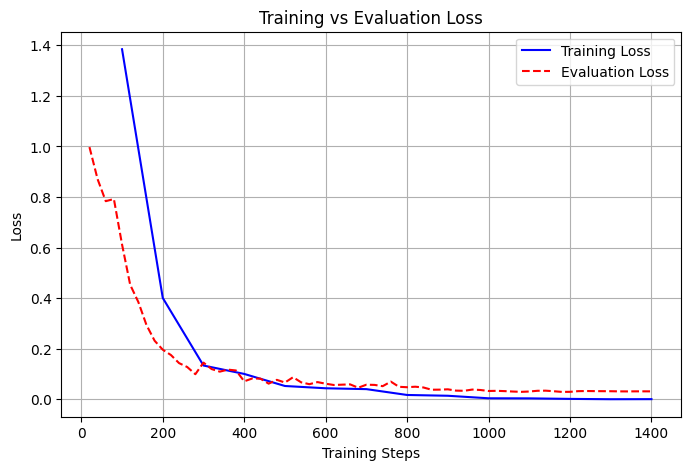

In [13]:
import matplotlib.pyplot as plt

# Extract training and evaluation losses with corresponding steps
train_losses = [(log["step"], log["loss"]) for log in trainer.state.log_history if "loss" in log]
eval_losses = [(log["step"], log["eval_loss"]) for log in trainer.state.log_history if "eval_loss" in log]

# Unpack steps and losses separately
train_steps, train_loss_values = zip(*train_losses) if train_losses else ([], [])
eval_steps, eval_loss_values = zip(*eval_losses) if eval_losses else ([], [])

# Plot both training and evaluation loss
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_loss_values, label="Training Loss", color="blue", linestyle="-")
plt.plot(eval_steps, eval_loss_values, label="Evaluation Loss", color="red", linestyle="--")

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid()

plt.show()


In [14]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np

# Load processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("./trOCR_v2/checkpoint-1404")  # Update path to your trained model

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def predict(example):
    try:
        # Convert image to pixel values using processor
        if "image" in example:
            image = example["image"]
            
            # Ensure it's a PIL Image (some datasets might store it differently)
            if not isinstance(image, Image.Image):
                image = Image.open(image).convert("RGB")

            # Convert image to tensor
            pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

        else:
            raise KeyError("No 'image' key found in dataset")

        # Generate text
        with torch.no_grad():
            generated_ids = model.generate(pixel_values)

        predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return {"predicted_text": predicted_text, "image": image}

    except Exception as e:
        print(f"Error processing example: {e}")
        return {"predicted_text": "Error", "image": None}


# Run inference on test set
test_predictions = dataset_test.map(predict)


Map:   0%|          | 0/467 [00:00<?, ? examples/s]c:\Users\Amrit Baskota\Desktop\DevNagariOCR\trocr_env\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Map: 100%|██████████| 467/467 [07:28<00:00,  1.04 examples/s]


In [199]:
# check available fonts

import matplotlib.font_manager as fm

# Get a list of all font paths
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# Print all font names
for font in font_list:
    print(font)


C:\Windows\Fonts\BELLB.TTF
C:\Windows\Fonts\malgunbd.ttf
C:\Windows\Fonts\sylfaen.ttf
C:\Windows\Fonts\consola.ttf
C:\Windows\Fonts\impact.ttf
C:\Windows\Fonts\GOTHIC.TTF
C:\Windows\Fonts\calibril.ttf
C:\Windows\Fonts\Candarali.ttf
C:\Windows\Fonts\ROCCB___.TTF
C:\Windows\Fonts\PERI____.TTF
C:\Windows\Fonts\GIGI.TTF
C:\Windows\Fonts\msjh.ttc
C:\Windows\Fonts\BRLNSDB.TTF
C:\Windows\Fonts\PERBI___.TTF
C:\Windows\Fonts\HPSimplified_Rg.ttf
C:\Windows\Fonts\BOD_BI.TTF
C:\Windows\Fonts\Candarai.ttf
C:\Windows\Fonts\trebuc.ttf
C:\Windows\Fonts\ebrimabd.ttf
C:\Windows\Fonts\verdanab.ttf
C:\Windows\Fonts\FRAHV.TTF
C:\Windows\Fonts\himalaya.ttf
C:\Windows\Fonts\MATURASC.TTF
C:\Windows\Fonts\FRADMCN.TTF
C:\Windows\Fonts\HARLOWSI.TTF
C:\Windows\Fonts\taileb.ttf
C:\Windows\Fonts\BRUSHSCI.TTF
C:\Windows\Fonts\calibriz.ttf
C:\Users\Amrit Baskota\AppData\Local\Microsoft\Windows\Fonts\Ganess Regular.ttf
C:\Windows\Fonts\palab.ttf
C:\Windows\Fonts\msjhbd.ttc
C:\Windows\Fonts\calibrib.ttf
C:\Windows\Font

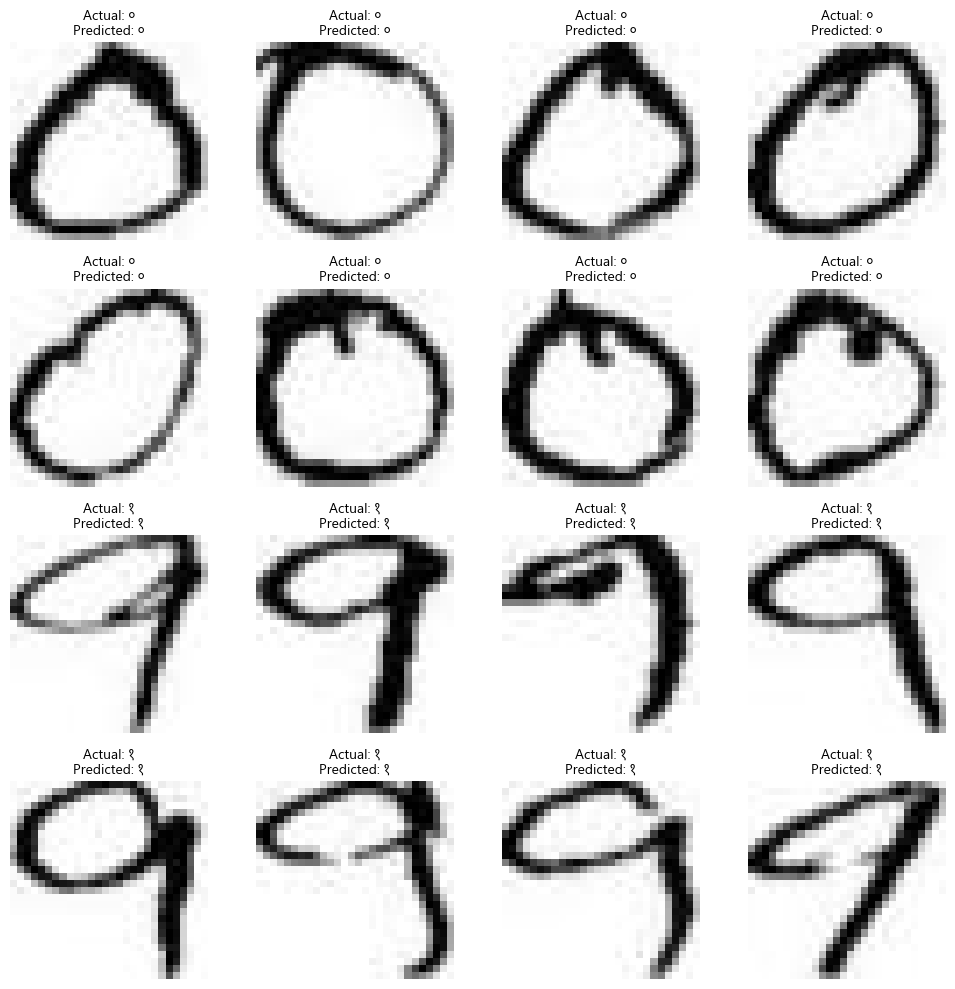

In [202]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams['font.family'] = 'Nirmala UI'

# Create a 5x5 grid for 25 images (adjust size to fit better)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))  

for i, ax in enumerate(axes.flat):
    if i >= 16:  # Ensure we don't exceed available images
        break
    
    actual_text = dataset_test[i]["label"]
    predicted_text = test_predictions[i]["predicted_text"]
    image = test_predictions[i]["image"]

    if image:
        ax.imshow(np.array(image))  # Convert PIL image to NumPy array
        ax.axis("off")
        ax.set_title(f"Actual: {actual_text}\nPredicted: {predicted_text}", 
                     fontsize=10, fontweight="bold")  # Larger bold text

plt.tight_layout()
plt.show()


In [203]:
def create_label_mapping(csv_files):
    """
    Reads multiple CSV files and extracts mappings from Devanagari Label to (Label, Phonetics).
    
    :param csv_files: List of CSV file paths
    :return: Dictionary with Devanagari Label as key and (Label, Phonetics) as value
    """
    label_map = {}

    for file in csv_files:
        df = pd.read_csv(file)
        
        # Ensure the necessary columns exist
        if {"Devanagari Label", "Label", "Phonetics"}.issubset(df.columns):
            for _, row in df.iterrows():
                devanagari_label = str(row["Devanagari Label"]).strip()
                label = str(row["Label"]).strip()
                phonetics = str(row["Phonetics"]).strip()
                
                if devanagari_label:  # Avoid empty labels
                    label_map[devanagari_label] = (label, phonetics)
    
    return label_map

# Example usage
csv_files = ["./dataset/Vowels.csv", "./dataset/Consonants.csv", "./dataset/Numerals.csv"]
label_mapping = create_label_mapping(csv_files)

# Print the first few mappings
for key, value in list(label_mapping.items())[:5]:
    print(f"{key}: {value}")


अ: ('a', 'a')
आ: ('aa', 'ā')
इ: ('i', 'i')
ई: ('ee', 'ī')
उ: ('u', 'u')


In [ ]:
# import torch
# from transformers import TrOCRProcessor, VisionEncoderDecoderModel
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# Load processor and model
# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# model = VisionEncoderDecoderModel.from_pretrained("./trOCR_v2/checkpoint-1404")  # Update path to trained model

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
def predict_by_path(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
        
        with torch.no_grad():
            generated_ids = model.generate(pixel_values)
        
        predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return image, predicted_text
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, "Error"




अः
अं: ('an', 'aṁ')


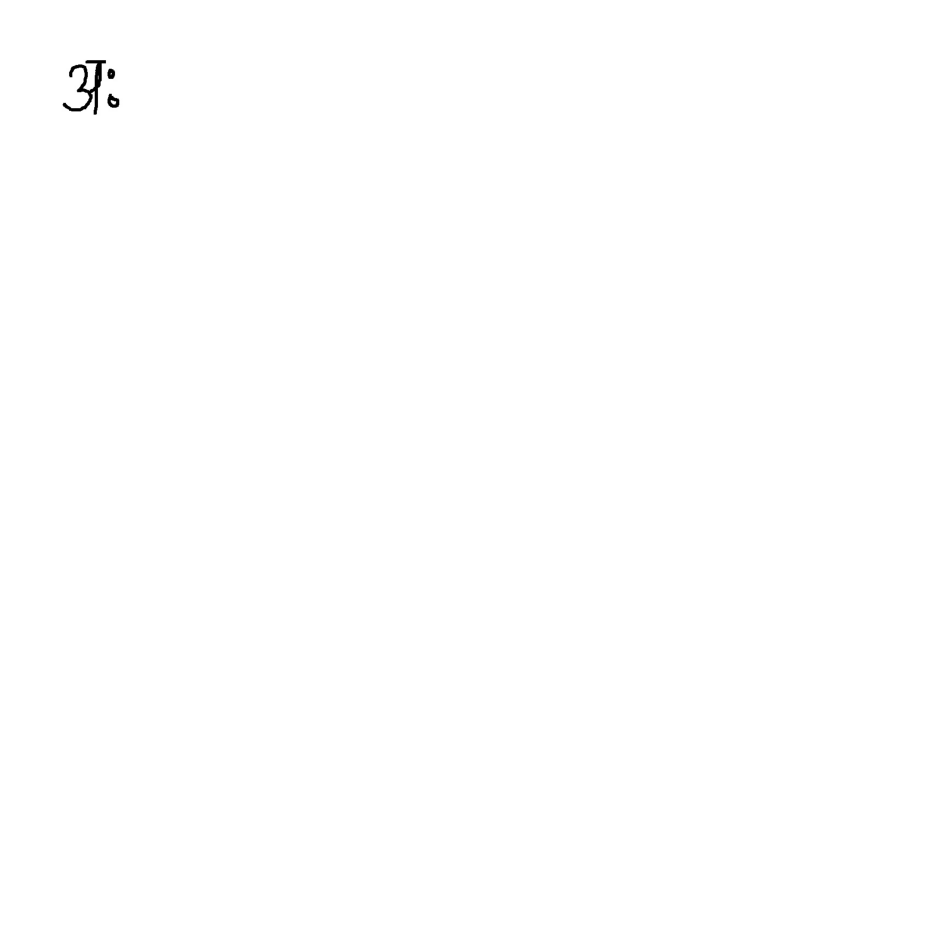

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def correct_special_characters(text):
    corrections = {
        "क�": "क्ष",
        "त�": "त्र",
        "ज�": "ज्ञ",
        "अ�": "अं"
    }
    
    # Replace incorrect model outputs with correct characters
    for key, value in corrections.items():
        if key in text:
            text = text.replace(key, value)
    
    return text

# print(dataset_test[170]['label'])

# Load images from the 'try' directory
image_dir = "try"
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Plot images with predictions
fig, axes = plt.subplots(5, 5, figsize=(12, 12))  # 5x5 grid

for i, ax in enumerate(axes.flat):
    if i >= len(image_files):
        ax.axis("off")
        continue
    
    image, predicted_text = predict_by_path(image_files[i])
    predicted_text=correct_special_characters(predicted_text)
    print(f"{predicted_text}: {label_mapping[predicted_text]}")
    
    if image:
        ax.imshow(np.array(image))  # Convert PIL image to NumPy array
        ax.axis("off")
        


In [204]:
from jiwer import wer

# Function to calculate WER (Word Error Rate)
def calculate_wer(example):
    return {"wer": wer(example["label"], example["predicted_text"])}

# Apply evaluation metric
wer_results = test_predictions.map(calculate_wer)

# Get average WER
average_wer = sum(wer_results["wer"]) / len(wer_results)
print(f"Average WER: {average_wer:.4f}")  # Lower WER is better


Map: 100%|██████████| 467/467 [00:00<00:00, 6909.79 examples/s]

Average WER: 0.1006


In [206]:
from torch.nn import CrossEntropyLoss

# Define loss function
loss_fn = CrossEntropyLoss()

# Compute loss on test dataset
def compute_loss(example):
    # Ensure the dataset contains images
    if "image" not in example:
        raise ValueError("Dataset example does not contain 'image' key.")
    
    # Process the image correctly
    image = example["image"]
    if isinstance(image, str):  # If it's a file path, load it
        from PIL import Image
        image = Image.open(image).convert("RGB")

    # Convert image using the processor
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    
    # Tokenize the label
    labels = processor.tokenizer(example["label"], return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

    with torch.no_grad():
        outputs = model(pixel_values, labels=labels)
        loss = outputs.loss
    
    return {"loss": loss.item()}


# Map loss function over test dataset
loss_results = dataset_test.map(compute_loss)

# Compute average loss
average_loss = sum(loss_results["loss"]) / len(loss_results)
print(f"Average Loss: {average_loss:.4f}")


Map: 100%|██████████| 467/467 [04:19<00:00,  1.80 examples/s]

Average Loss: 0.6522


In [208]:
import evaluate
import numpy as np

# Load WER and CER metrics
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

# Function to evaluate OCR results
def compute_metrics(eval_preds):
    preds = eval_preds.predictions  # Extract predictions
    labels = eval_preds.label_ids   # Extract labels
    
    # Convert logits to token indices if needed (for classification models)
    if isinstance(preds, tuple):  
        preds = preds[0]  # Take first output if multiple exist

    # Decode predictions and labels
    decoded_preds = [processor.tokenizer.decode(p, skip_special_tokens=True) for p in preds]
    decoded_labels = [processor.tokenizer.decode(l, skip_special_tokens=True) for l in labels]

    # Compute WER and CER
    wer = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)

    # Compute Word-Level Accuracy
    correct_words = sum(1 for pred, label in zip(decoded_preds, decoded_labels) if pred == label)
    total_words = len(decoded_labels)
    word_accuracy = correct_words / total_words if total_words > 0 else 0

    # Compute Character-Level Accuracy
    correct_chars = sum(sum(1 for pc, lc in zip(pred, label) if pc == lc) for pred, label in zip(decoded_preds, decoded_labels))
    total_chars = sum(len(label) for label in decoded_labels)
    char_accuracy = correct_chars / total_chars if total_chars > 0 else 0

    return {"WER": wer, "CER": cer, "Word Accuracy": word_accuracy, "Char Accuracy": char_accuracy}

# Evaluate on validation dataset
eval_results = trainer.predict(dataset_validate)
metrics = compute_metrics(eval_results)

print(metrics)


c:\Users\Amrit Baskota\Desktop\DevNagariOCR\trocr_env\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 59/59 [07:15<00:00,  7.38s/it]

{'WER': 0.03854389721627409, 'CER': 0.039525691699604744, 'Word Accuracy': 0.961456102783726, 'Char Accuracy': 0.9604743083003953}
